In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import math
from scipy import optimize
from condensation_temperature import *
from tqdm import tqdm
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
t= Table.read('solar_twins_data.fits') #fits file as table 

exclusions = ['HIP19911', 'HIP108158', 'HIP109821', 'HIP115577', 'HIP14501', 'HIP28066', 'HIP30476',
              'HIP33094', 'HIP65708', 'HIP73241', 'HIP74432', 'HIP64150']
for u in exclusions:
    for i, txt in enumerate(t['star_name']):
        if txt == u:
            t.remove_row(i)

for i, words in enumerate(t['Fe']):
   t['Fe'][i] = 0

t['O'][8] = 0
t['O_err'][8] = 10**6

In [3]:
def lnL(param, x, y, error): # Hogg: lnL = -1/2 sum [(y- (mx+b))^2/(err^2 + d^2)] -1/2 sum ln(err^2 + d^2)
    x = np.array(x)
    y = np.array(y)
    error = np.array(error)
    (m,b, jitter) = param 

    sum1 = 0
    for j, val in enumerate(x):
        mxb = m*val + b
        value = ((y[j] - mxb)**2)/((error[j]**2) + (jitter**2))
        sum1 = sum1 + value 
    sum1 = sum1 *(-1/2)
    
    num = 0
    for e, ooh in enumerate(error):
        val2 = np.log((ooh**2) + (jitter**2))
        num = num + val2 
    num = num * (-1/2)
    
    lnL = sum1 + num
    return lnL

def nlnL(param, x, y, error):
    nlnL= lnL(param, x,y, error)
    return - nlnL

def find_m_b(x,y,err):
    #C     
    errorsq = np.square(err)
    C = np.diag(errorsq)

    #A 
    xb = ([1] * len(x))
    mata = []
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
    A= np.matrix(mata).reshape((len(x), 2))

    #plugging in 
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)

    m = float(cov[0])
    b = float(cov[1])
    return m ,b 

def residuals(x, y, error):
    mborig = find_m_b(x, y, error)
    m = mborig[0]
    b = mborig[1]

    predicted_values = [] #y values from slope
    pv = 0
    for u in x:
        pv = (m*u) + b
        predicted_values.append(pv)
        pv = 0

    prev = np.array(predicted_values)
    abu = np.array(y)
    diff = abu - prev #difference between slope and measured values  
    return diff

def stdev(x):
    mean = np.mean(x)
    fun = 0
    for c in x: 
        j = (c-mean)**2
        fun = fun + j 
    s = np.sqrt(fun/(len(x)))
    return s

#chi squared, Hogg 2010 eq 7 :  [Y - AX]^T C^-1 [Y - AX] 
def chisquared(param, x, y, erro):
    for h, txt in enumerate(y): #removing nan values
        if (math.isnan(txt) == True):
            del x[h]
            del y[h]
            del erro[h]

    (m,b) = param #for optimization - m and b 
    X = (m,b)
    
    #A 
    ab = ([1] * len(x))
    Amat = []
    for z, txt in enumerate(x):
        Amat.append(x[z])
        Amat.append(ab[z])
    A= np.array(Amat).reshape((len(x), 2))

    #C  
    errorsq = np.square(erro)
    C = np.diag(errorsq)
    invsC = np.linalg.inv(C)

    #plugging in  
    AT= np.transpose(A)
    AX = np.dot(A,X)
    yax = (y - AX)
    yaxT = np.transpose(yax)
    yaxTinvsC = np.dot(yaxT, invsC)

    chisq = (np.dot(yaxTinvsC, yax))
    return (chisq)

def delta(param, x, y): # Hogg 2010 eqn 30 : ∆i = (vˆT Zi) − b cos θ   
    (m,b, jitter) = param
    theta = np.arctan(m)
    v = np.array([- np.sin(theta), np.cos(theta)]) # v = [− sin θ  cos θ]   

    disp = np.zeros_like(y)
    for i, (ys, xs) in enumerate(zip(y, x)):
        z0 = np.asarray([0.0, b])
        zi = np.asarray([xs, ys])
        disp[i] = np.dot( v, zi - z0 )
    return disp

#2D uncertainties: lnL = K -  sum [delta^2 / 2* sum^2]  
def twodnlnL(param, x, y, errx, erry):
    K = 0
    delt = delta(param, x, y)
    (m,b,jitter) = param

    #Σ^2 = vˆT Si v  
    theta = np.arctan(m)
    v = np.array([- np.sin(theta), np.cos(theta)]) # v = [− sin θ,  cos θ]
    
    var = np.zeros_like(erry)
    for i, (dy, dx) in enumerate(zip(erry, errx)):
        cov = np.eye(2)
        cov[0,0] = dx**2
        cov[1,1] = dy**2 
        var[i] = np.dot(v.T, np.dot(cov, v))
        
    sigmasq = var + np.exp(2.*jitter)
    return 0.5 * np.sum(delt**2/sigmasq + np.log(sigmasq))


In [4]:
#1D LIKELIHOODS

In [5]:
one_d_jitter = []
one_d_residuals_jitter= []
ig = (0.1, 0.2, 0.3)

elements = []
for n in t.colnames:
    if len(n) < 3 :
        elements.append(n) #list of element names
elements = np.array(elements)
    
for r, name in enumerate(elements):
    #BEFORE REMOVING TEMP TRENDS
    jitter_one_d = scipy.optimize.minimize(nlnL, ig, args = (t['age'], t[name], t[name + '_err']))
    one_d_jitter.append(jitter_one_d['x'][2]) #list of age vs element jitter values

    age_abund_resid =  residuals(t['age'], t[name], t[name + '_err']) #removing condensation temp trends 
    
    #AFTER REMOVING TEMP
    residuals_jitter = scipy.optimize.minimize(nlnL, ig, args = (t['age'], age_abund_resid, t[name + '_err']))
    one_d_residuals_jitter.append(residuals_jitter['x'][2])

In [22]:
Table([elements, np.log(one_d_jitter), np.log(one_d_residuals_jitter), np.array(one_d_jitter)/np.array(one_d_residuals_jitter)], 
      names = ('Element','Jitter', "Residual's Jitter", 'Divided')).show_in_notebook()

idx,Element,Jitter,Residual's Jitter,Divided
0,Fe,nan,nan,1.0
1,O,-3.7157026881729838,-3.7157027791905555,1.0000000910175755
2,Na,-3.5964581973732983,-3.596458192427378,0.9999999950540797
3,Mg,nan,nan,1.000000005795207
4,Al,-4.0939685687410075,-4.093968569006734,1.0000000002657257
5,Si,-4.478540741442575,-4.478540741652311,1.0000000002097365
6,S,nan,-3.6978716824382363,-1.0000014621217999
7,Ca,-4.719654647831988,-4.7196549604259435,1.0000003125940047
8,V,-4.686711582632222,nan,-0.999997779339432
9,Mn,-3.877786722211176,-3.8777867225541596,1.0000000003429834


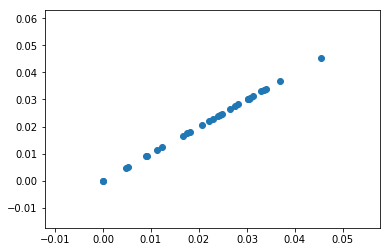

In [7]:
plt.scatter(np.absolute(np.array(one_d_jitter)), np.absolute(np.array(one_d_residuals_jitter)))

In [8]:
standarddev = []
standarddev_residuals = []
initial_guess = (0.1, 0.1)

for p in elements:
    standarddev.append(stdev(t[p]))
    resid = residuals(t['age'], t[p], t[p + '_err'])
    standarddev_residuals.append(stdev(resid))

In [9]:
Table([elements, standarddev, standarddev_residuals, np.array(standarddev)/np.array(standarddev_residuals)], 
      names = ('Element','Standard Deviation', "Residual's Standard Deviation", 'Divided'))

Element,Standard Deviation,Residual's Standard Deviation,Divided
str2,float64,float64,float64
Fe,0.0,0.0,nan
O,0.033611419319191496,0.026719476522191497,1.2579370442110267
Na,0.03595281172982548,0.029209208399030934,1.2308725124854214
Mg,0.02996596613322483,0.016754876051260633,1.788492259897691
Al,0.038449476465674134,0.0182233174856738,2.109905427258295
Si,0.019251252599340084,0.011891489271426116,1.6189101432062538
S,0.03854360986715821,0.032257028387927114,1.194890285727125
Ca,0.010348971498301865,0.010006651266438779,1.0342092696895704
V,0.012400154871228418,0.012162507827491653,1.0195393127065124


In [10]:
Table([elements, np.absolute(one_d_jitter), np.absolute(one_d_residuals_jitter), standarddev, standarddev_residuals], 
      names = ('Element', 'Jitter',"Residual's Jitter",'Standard Deviation',"Residual's StDev"))

Element,Jitter,Residual's Jitter,Standard Deviation,Residual's StDev
str2,float64,float64,float64,float64
Fe,1.2875109690469402e-08,1.2875109690469402e-08,0.0,0.0
O,0.02433833284619741,0.024338330630981564,0.033611419319191496,0.026719476522191497
Na,0.027420669261122917,0.027420669396743362,0.03595281172982548,0.029209208399030934
Mg,0.012354494073977965,0.012354494002381115,0.02996596613322483,0.016754876051260633
Al,0.01667293440292503,0.016672934398494606,0.038449476465674134,0.0182233174856738
Si,0.011349963607556253,0.011349963605175753,0.019251252599340084,0.011891489271426116
S,0.024776238247006144,0.02477620202118105,0.03854360986715821,0.032257028387927114
Ca,0.008918257956388969,0.00891825516859587,0.010348971498301865,0.010006651266438779
V,0.009216945540026807,0.009216966007779777,0.012400154871228418,0.012162507827491653


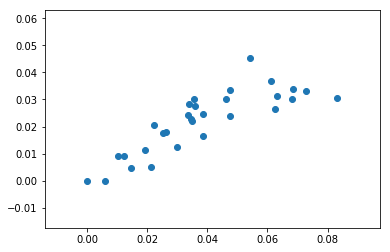

In [11]:
plt.scatter(standarddev, np.absolute(one_d_jitter))

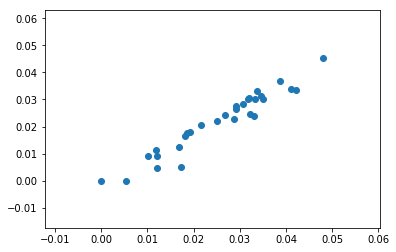

In [12]:
plt.scatter(standarddev_residuals, np.absolute(one_d_residuals_jitter))

In [13]:
scatter_jitter = []
scatter_residuals_jitter =[]
guess = (0.1,0.2,0.3)

con_temp = []
for i in elements: 
    con_temp.append(tc_map[i]) #condensation temperatures of elements 
temp_shuffle = np.copy(con_temp)
random.shuffle(temp_shuffle) #random condensation temperatures assigned to elements : testing impact
    
star_abund = []
abund_error = []
for n, star in enumerate(t['star_name']):
    individual_elements =[]
    individual_error = []
    for u in elements:
        individual_elements.append(t[n][u]) #abundances of elements in every star
        individual_error.append(t[n][u + '_err']) #error on abundances
    star_abund.append(individual_elements)
    abund_error.append(individual_error)
    individual_elements=[]
    individual_error =[]

for j, star in enumerate(t['star_name']):
    jitter_temp = scipy.optimize.minimize(nlnL, guess, args = (temp_shuffle, star_abund[j], abund_error[j]))
    scatter_jitter.append(jitter_temp['x'][2]) #list of temp vs element jitter values

    #removing temperature trends
    temp_abund_residuals = residuals(temp_shuffle, star_abund[j], abund_error[j])
    jitter_no_temp = scipy.optimize.minimize(nlnL, guess, args = (temp_shuffle, temp_abund_residuals, abund_error[j]))
    scatter_residuals_jitter.append(jitter_no_temp['x'][2])

In [14]:
Table([t['star_name'], scatter_jitter, scatter_residuals_jitter, np.array(scatter_jitter)/np.array(scatter_residuals_jitter)],
      names = ('Star',"Scattered Temp Jitter", "Residual Scatter Jitter", 'Divided'))

Star,Scattered Temp Jitter,Residual Scatter Jitter,Divided
bytes9,float64,float64,float64
HIP10175,0.06003985815755665,0.060037515056598136,1.0000390272807977
HIP101905,0.07177975446940481,0.07178078090735604,0.9999857003791508
HIP102040,0.07000073208899626,0.07000183007204186,0.9999843149379886
HIP102152,0.03654812912525867,0.03655447731329167,0.9998263362384149
HIP10303,0.0170973062819332,-0.017099704810351325,-0.999859732758856
HIP104045,-0.02241036319057468,-0.02241023229544649,1.0000058408644081
HIP105184,0.08474223488384232,0.08474885259292618,0.999921913879877
HIP108468,-0.04699123059373722,0.04700329254392648,-0.9997433807391687
HIP114328,0.03155809980496915,0.03155969970384566,0.9999493056368876


In [15]:
scipy.optimize.minimize(chisquared, (0.00849329, -0.03046105), args = (t['age'], t['Mg'], t['Mg_err']))

      fun: 298.5808584426217
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0.11561966, 0.00435257])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 184
      nit: 0
     njev: 43
   status: 2
  success: False
        x: array([ 0.00849329, -0.03046105])

In [16]:
Table([standarddev, standarddev_residuals])

col0,col1
float64,float64
0.0,0.0
0.033611419319191496,0.026719476522191497
0.03595281172982548,0.029209208399030934
0.02996596613322483,0.016754876051260633
0.038449476465674134,0.0182233174856738
0.019251252599340084,0.011891489271426116
0.03854360986715821,0.032257028387927114
0.010348971498301865,0.010006651266438779
0.012400154871228418,0.012162507827491653


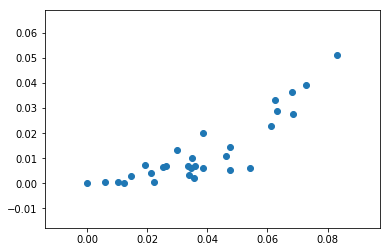

In [17]:
plt.scatter(standarddev, np.array(standarddev)-np.array(standarddev_residuals))

In [18]:
#2D LIKELIHOODS

In [19]:
standarddev = []
standarddev_resid = []

for p in elements:
    standarddev.append(stdev(t[p]))
    resid = residuals(t['age'], t[p], t[p + '_err'])
    standarddev_resid.append(stdev(resid))

In [20]:
jitter = []
residual_jitter = []
no_temp = []
initial_guess = (0.1, 0.2, 0.3)     
    
for l, el in tqdm(enumerate(elements)):
    resid = residuals(t['age'], t[el], t[el + '_err'])
    
    #BEFORE REMOVING TEMP TRENDS
    jit_twod = scipy.optimize.minimize(twodnlnL, initial_guess, args = (t['age'], t[el], t['age_err'], t[el+'_err']))
    jitter.append(jit_twod['x'][2])
    
    #AFTER REMOVING TEMP
    #resid_jit = scipy.optimize.minimize(twodnlnL, initial_guess, args = (t['age'], resid, t['age_err'], t[el+'_err']))
    #residual_jitter.append(resid_jit['x'])
    el_no_temp = t[el] - resid
    jit_no_temp = scipy.optimize.minimize(twodnlnL, initial_guess, args = (t['age'], el_no_temp, t['age_err'], t[el+'_err']))
    no_temp.append(jit_no_temp['x'][2])

30it [01:16,  1.97s/it]


In [21]:
Table([elements, jitter, no_temp, standarddev, standarddev_resid], 
      names = ('Element','Jitter', "Residual's Jitter", 'StDev', 'StDev Resid'))

Element,Jitter,Residual's Jitter,StDev,StDev Resid
str2,float64,float64,float64,float64
Fe,-14.669538220741654,-14.669538220741654,0.0,0.0
O,-3.731888400273421,-12.805659062018984,0.033611419319191496,0.026719476522191497
Na,-3.60207232012489,-13.259245371897851,0.03595281172982548,0.029209208399030934
Mg,-4.433994549835249,-13.419110697816775,0.02996596613322483,0.016754876051260633
Al,-4.153910771083712,-14.199957769096846,0.038449476465674134,0.0182233174856738
Si,-4.501752857278109,-14.174041407636427,0.019251252599340084,0.011891489271426116
S,-3.7137691250711775,-14.265054631635032,0.03854360986715821,0.032257028387927114
Ca,-4.7207305167869755,-14.10006876710241,0.010348971498301865,0.010006651266438779
V,-4.687944683830601,-14.708407993824055,0.012400154871228418,0.012162507827491653


In [34]:
Table([np.log(one_d_jitter), jitter, np.log(np.absolute(one_d_residuals_jitter)), no_temp], names =('1D Jitter', 
            '2D Jitter','1D Residual Jitter', '2D Residual Jitter'))

1D Jitter,2D Jitter,1D Residual Jitter,2D Residual Jitter
float64,float64,float64,float64
nan,-14.669538220741654,-18.167969870784795,-14.669538220741654
-3.7157026881729838,-3.731888400273421,-3.7157027791905555,-12.805659062018984
-3.5964581973732983,-3.60207232012489,-3.596458192427378,-13.259245371897851
nan,-4.433994549835249,-4.393735395266429,-13.419110697816775
-4.0939685687410075,-4.153910771083712,-4.093968569006734,-14.199957769096846
-4.478540741442575,-4.501752857278109,-4.478540741652311,-14.174041407636427
nan,-3.7137691250711775,-3.6978716824382363,-14.265054631635032
-4.719654647831988,-4.7207305167869755,-4.7196549604259435,-14.10006876710241
-4.686711582632222,-4.687944683830601,-4.686709361969189,-14.708407993824055
